In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.stattools import jarque_bera

import warnings
warnings.filterwarnings("ignore")


In [8]:
def do_dickey_fuller_test(serie, alpha=0.05):
    # Dickey-Fuller
    print("\nDickey-Fuller Test for Deterministic Residuals:")
    adf_det = ts.adfuller(serie.dropna())
    print(f"ADF Statistic: {adf_det[0]:.4f}, p-value: {adf_det[1]:.4f}")
    if adf_det[1] < alpha:
        print("Reject the null hypothesis (H0): The series is stationary.")
    else:
        print("Fail to reject H0: The series is non-stationary (unit root present).")

# 1. Input data

In [9]:
# Load the Excel file
file_path = "data/INE_IPC.xlsx"  # Path to the file
df = pd.read_excel(file_path).rename(columns={"    Índice general": "ig", 'Unnamed: 0': 'date'})[['date', 'ig']]#.set_index('date')

# Convert 'date' from "yyyyMmm" format to datetime
df['date'] = pd.to_datetime(df['date'].astype(str).str[:4] + '-' + df['date'].astype(str).str[5:7])

# Set the index to the new datetime format
df = df.set_index('date')

# Display the first few rows
print(df.head())


                ig
date              
2002-01-01  69.530
2002-02-01  69.590
2002-03-01  70.165
2002-04-01  71.118
2002-05-01  71.374


# 2. Compute annual inflation

We compute the annual inflation of Indice General using the expression:

$$
y_t = 100 \Delta_{12} \log(P_t) = 100 \times (\log(P_t) - \log(P_{t-12})).
$$


In [10]:
# Compute annual inflation
df['inflation'] = 100 * (np.log(df['ig']) - np.log(df['ig'].shift(12)))

# Drop NaN values resulting from the shift operation
df = df.dropna()

# Display the first few rows of the inflation column
print(df[['inflation']].head())

            inflation
date                 
2003-01-01   3.644828
2003-02-01   3.770520
2003-03-01   3.638546
2003-04-01   3.099746
2003-05-01   2.647687


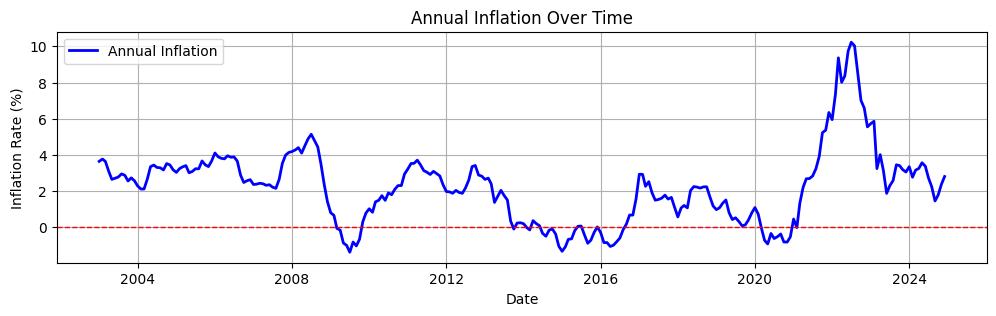

In [11]:
# Drop NaN values resulting from the shift operation
df = df.dropna()

# Plot the inflation time series
plt.figure(figsize=(12, 3))
plt.plot(df.index, df['inflation'], label='Annual Inflation', color='b', linewidth=2)
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)  # Reference line at zero inflation
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.title('Annual Inflation Over Time')
plt.legend()
plt.grid(True)
plt.show()

The inflation is non-stationary. As we can see, the Dickey-Fuller test statistic is almost rejecting the null hypotesis (p-value=0.0518). But just to be sure of the stationarity, we decided to be strict about it and consider it non-stationary.

In [12]:
do_dickey_fuller_test(df['inflation'])


Dickey-Fuller Test for Deterministic Residuals:
ADF Statistic: -2.8531, p-value: 0.0511
Fail to reject H0: The series is non-stationary (unit root present).


# 3. Stationary transformation
We will assume stochastic trend and we will use the first difference of the series to make it stationary. Now, the plot looks more stationary and the Dickey-Fuller test statistic is rejecting the null hypotesis (p-value=0.0005).

In [13]:
df['diff_inflation'] = df['inflation'].diff()
do_dickey_fuller_test(df['diff_inflation'].dropna())


Dickey-Fuller Test for Deterministic Residuals:
ADF Statistic: -4.2630, p-value: 0.0005
Reject the null hypothesis (H0): The series is stationary.


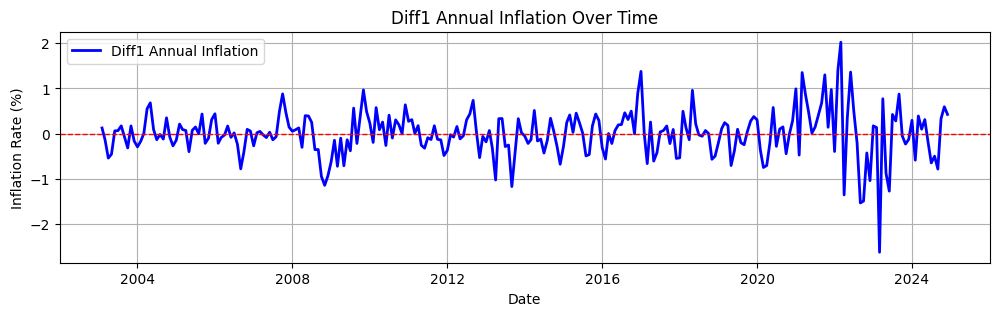

In [7]:
# Drop NaN values resulting from the shift operation
df = df.dropna()

# Plot the inflation time series
plt.figure(figsize=(12, 3))
plt.plot(df.index, df['diff_inflation'], label='Diff1 Annual Inflation', color='b', linewidth=2)
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)  # Reference line at zero inflation
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.title('Diff1 Annual Inflation Over Time')
plt.legend()
plt.grid(True)
plt.show()

As we see en in autocorrelation plot, both the autocorrelation and the partial autocorrelation decay exponentially. Also it seems to have some seasonality every 12 months.

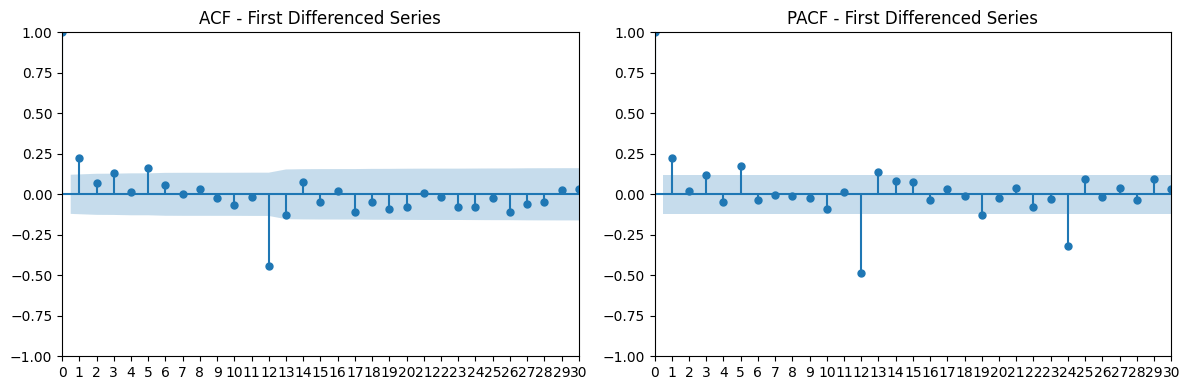

In [25]:


# Set up figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot ACF
sm.graphics.tsa.plot_acf(df['diff_inflation'], lags=30, ax=axes[0])
axes[0].set_title('ACF - First Differenced Series')
axes[0].set_xlim(1, 30)  # Start from lag 1
axes[0].set_xticks(np.arange(0, 31, 1))

# Plot PACF
sm.graphics.tsa.plot_pacf(df['diff_inflation'], lags=30, ax=axes[1], method='ywm')
axes[1].set_title('PACF - First Differenced Series')
axes[1].set_xlim(1, 30)  # Start from lag 1
axes[1].set_xticks(np.arange(0, 31, 1))

plt.tight_layout()
plt.show()


We will first try with an AR(1) model to keep it simple, and if that model is enough, we won't do anything else. Our objective is to find the simplest model that explains the serie and correctly separates the dependent part from the independent. We see how the coeficient is significant, but that is not enough to accept the model. As we can see, we have a high autocorrelation in the resuduals, and we should find that the residuals are white noise. This autocorrelation is to high to just ignore it, as it's far from the confidence interval. We will try to add a seasonal component to the model as the correlation is at lag 12.

                            AutoReg Model Results                             
Dep. Variable:         diff_inflation   No. Observations:                  263
Model:                     AutoReg(1)   Log Likelihood                -189.011
Method:               Conditional MLE   S.D. of innovations              0.498
Date:                Wed, 12 Mar 2025   AIC                            384.022
Time:                        20:31:33   BIC                            394.727
Sample:                    03-01-2003   HQIC                           388.325
                         - 12-01-2024                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0026      0.031     -0.084      0.933      -0.063       0.058
diff_inflation.L1     0.2264      0.060      3.758      0.000       0.108       0.345
                        

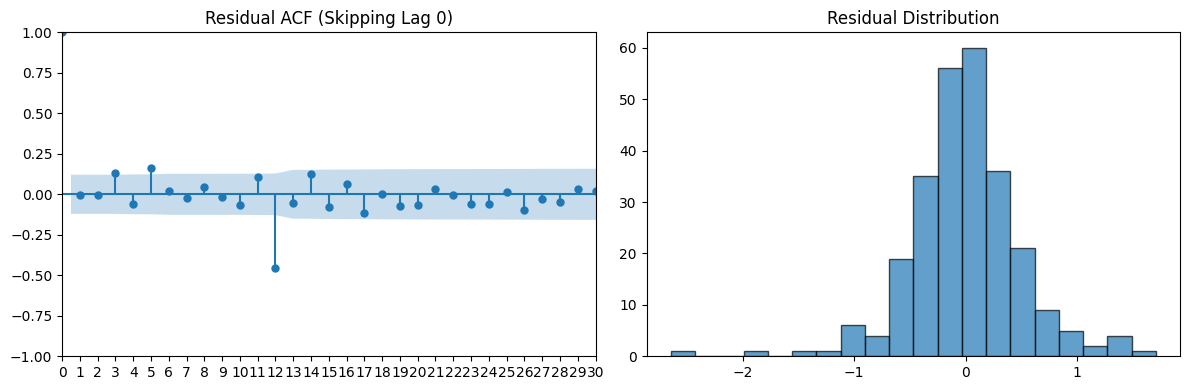

In [30]:
model = AutoReg(df['diff_inflation'].dropna(), lags=1).fit()
print(model.summary())

residuals = model.resid

# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Residual ACF Plot
sm.graphics.tsa.plot_acf(residuals, lags=30, ax=axes[0])
axes[0].set_title("Residual ACF (Skipping Lag 0)")
axes[0].set_ylim(-1, 1)  # Limit y-axis for better visualization

axes[0].set_xlim(1, 30)  # Start from lag 1
axes[0].set_xticks(np.arange(0, 31, 1))

# Residual Histogram
axes[1].hist(residuals, bins=20, edgecolor='black', alpha=0.7)
axes[1].set_title("Residual Distribution")

# Show the plots
plt.tight_layout()
plt.show()

# Jarque-Bera test for normality
#jb_stat, jb_pvalue, skew, kurtosis = jarque_bera(residuals)
#print(f"Jarque-Bera Test:")
#print(f"Test Statistic: {jb_stat}")
#print(f"P-value: {jb_pvalue}")
#print(f"Skewness: {skew}")
#print(f"Kurtosis: {kurtosis}")

# Interpretation of the test
#if jb_pvalue > 0.05:
#    print("Residuals appear to be normally distributed (Fail to reject H0).")
#else:
#    print("Residuals do not appear to be normally distributed (Reject H0).")'''

Now we will fit an seasonal ARMA model. The model is ARIMA(1,0,0)(1,0,0)[12]. Notice that the differentiation was done before. This new model adds a MA(1) component with periodicity 12. That is also justified by the partial autocorrelation plot of the differentiated series, which shows a significant peak at lag 12 and 24. All the coefficients are significant, except the constant. That makes sense as the mean of the serie is approximately 0.

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit AR(2) + Seasonal MA(12) model with a constant
model = SARIMAX(df['diff_inflation'], order=(1, 0, 0), seasonal_order=(0, 0, 1, 12), trend='c')

result = model.fit()

# Print model summary
print(result.summary())


                                      SARIMAX Results                                       
Dep. Variable:                       diff_inflation   No. Observations:                  264
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 12)   Log Likelihood                -127.895
Date:                              Wed, 12 Mar 2025   AIC                            263.791
Time:                                      20:40:44   BIC                            278.094
Sample:                                  01-01-2003   HQIC                           269.538
                                       - 12-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0001      0.006     -0.021      0.984      -0.011       0.011
ar.L1          0.27

Now the residuals look white noise. They have 0 mean, constant variance and no autocorrelation. Some autocorrelations are slightly outside the confidence interval, but this behaviour looks normal and we don't have any reason to think that they are actually correlated. Is not a Gaussian White Noise since the distribution is not normal according to the Jarque-Bera test. We conclude that the model is good enough to explain the serie. 

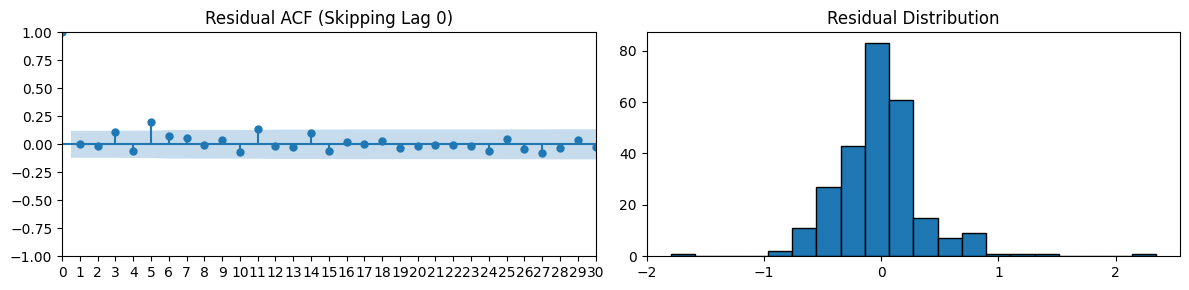

Residuals mean: -0.00815076606261758
Jarque-Bera Test:
Test Statistic: 553.6781953727593
P-value: 5.892607303824677e-121
Skewness: 0.8651933344280568
Kurtosis: 9.894311340109871
Residuals do not appear to be normally distributed (Reject H0).


In [34]:


# Plot residuals
residuals = result.resid.dropna()

fig, axes = plt.subplots(1, 2, figsize=(12, 3))

# ACF of residuals, skipping lag 0
sm.graphics.tsa.plot_acf(residuals, lags=30, ax=axes[0])
axes[0].set_xlim(1, 30)  # Start from lag 1
axes[0].set_xticks(np.arange(0, 31, 1))  # Show all numbers on the x-axis
axes[0].set_title("Residual ACF (Skipping Lag 0)")

# Histogram of residuals
axes[1].hist(residuals, bins=20, edgecolor='black')
axes[1].set_title("Residual Distribution")

plt.tight_layout()
plt.show()

print("Residuals mean:", residuals.mean())

# Jarque-Bera test for normality
jb_stat, jb_pvalue, skew, kurtosis = jarque_bera(residuals)
print(f"Jarque-Bera Test:")
print(f"Test Statistic: {jb_stat}")
print(f"P-value: {jb_pvalue}")
print(f"Skewness: {skew}")
print(f"Kurtosis: {kurtosis}")

# Interpretation of the test
if jb_pvalue > 0.05:
    print("Residuals appear to be normally distributed (Fail to reject H0).")
else:
    print("Residuals do not appear to be normally distributed (Reject H0).")
